## ORGANS: COVID

This notebook contains analysis measuring the extent to which transplants slowed down due to COVID-19.

---

### Initialize environment

In [2]:
library(tidyverse)

In [3]:
root_path     <- here::here()
data_path     <- paste0(root_path, "/01_data")
analysis_path <- paste0(root_path, "/02_analysis")

In [4]:
setwd(data_path)

transplant <- readRDS("clean/transplant_clean.rds")

transplant.raw <- as_tibble(read.csv("raw/04_transplant/TX_LI_22F218Records(2of2)-redacted.csv"))

state_code_mapping <- read.csv("raw/00_misc/state_code_mapping_20221022.csv")

setwd(analysis_path)

---

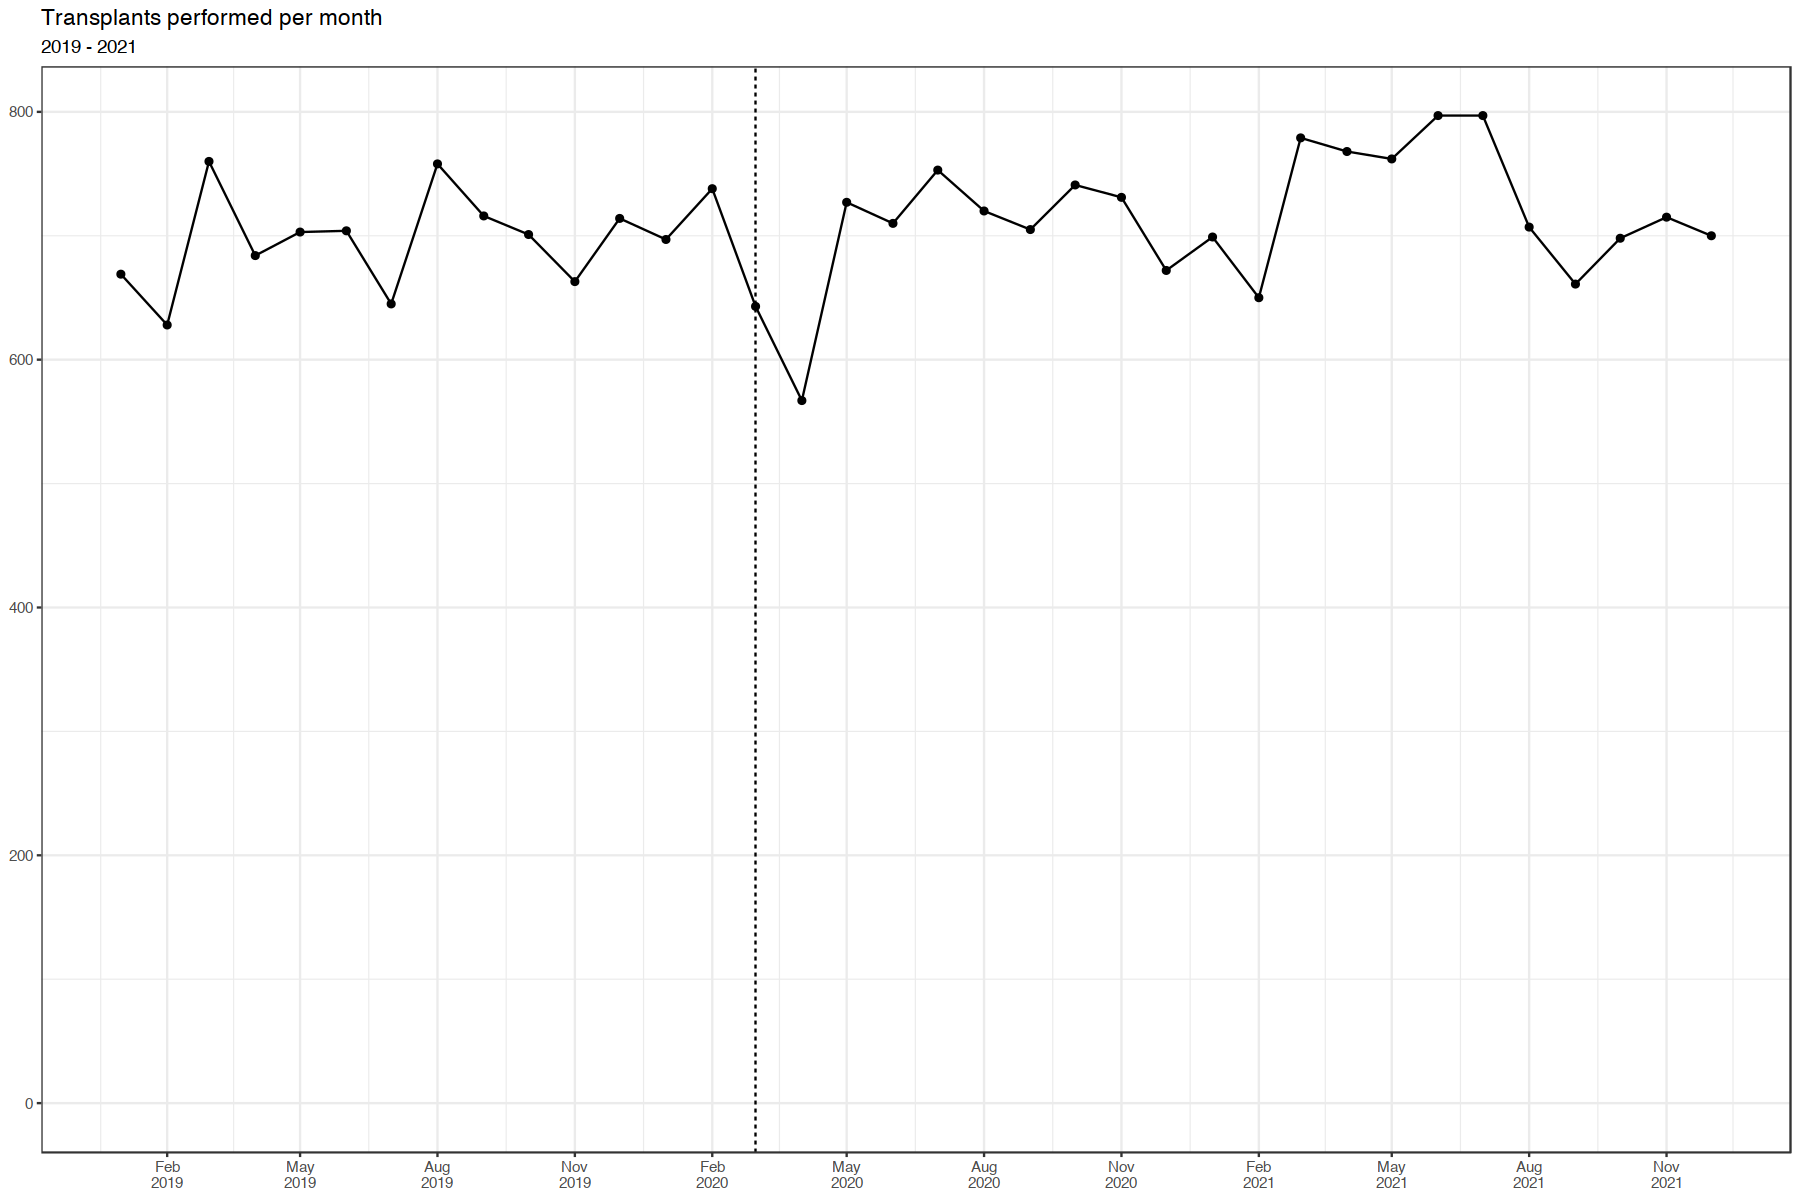

In [5]:
options(repr.plot.width = 15, repr.plot.height = 10)

txByMonthCOVID.dt <- transplant %>%
  filter(REC_TX_DT_YEAR %in% 2019:2021) %>%
  count(REC_TX_DT_MONTH = lubridate::floor_date(REC_TX_DT_DATE, "month"), name = "N_TX")

write.csv(txByMonthCOVID.dt, "output/tables/table8-tx_during_covid_months.csv",
          row.names = F)

txByMonthCOVID.plot1 <- txByMonthCOVID.dt %>%
  ggplot(aes(x = REC_TX_DT_MONTH, y = N_TX)) +
  geom_vline(xintercept = as.Date("2020-03-01"), linetype = "dashed") +
  geom_line() +
  geom_point() +
  scale_x_date(name = NULL, date_labels = "%b\n%Y", date_breaks = "3 months") +
  scale_y_continuous(name = NULL) +
  expand_limits(y = 0) +
  labs(title = "Transplants performed per month",
       subtitle = "2019 - 2021") +
  theme_bw()

ggsave("output/figures/fig8-transplants_per_month_around_covid.png",
       txByMonthCOVID.plot1, device = "png",
       width = 10, height = 6, unit = "in")

txByMonthCOVID.plot1

filter: removed 107 rows (<1%), 25,375 rows remaining



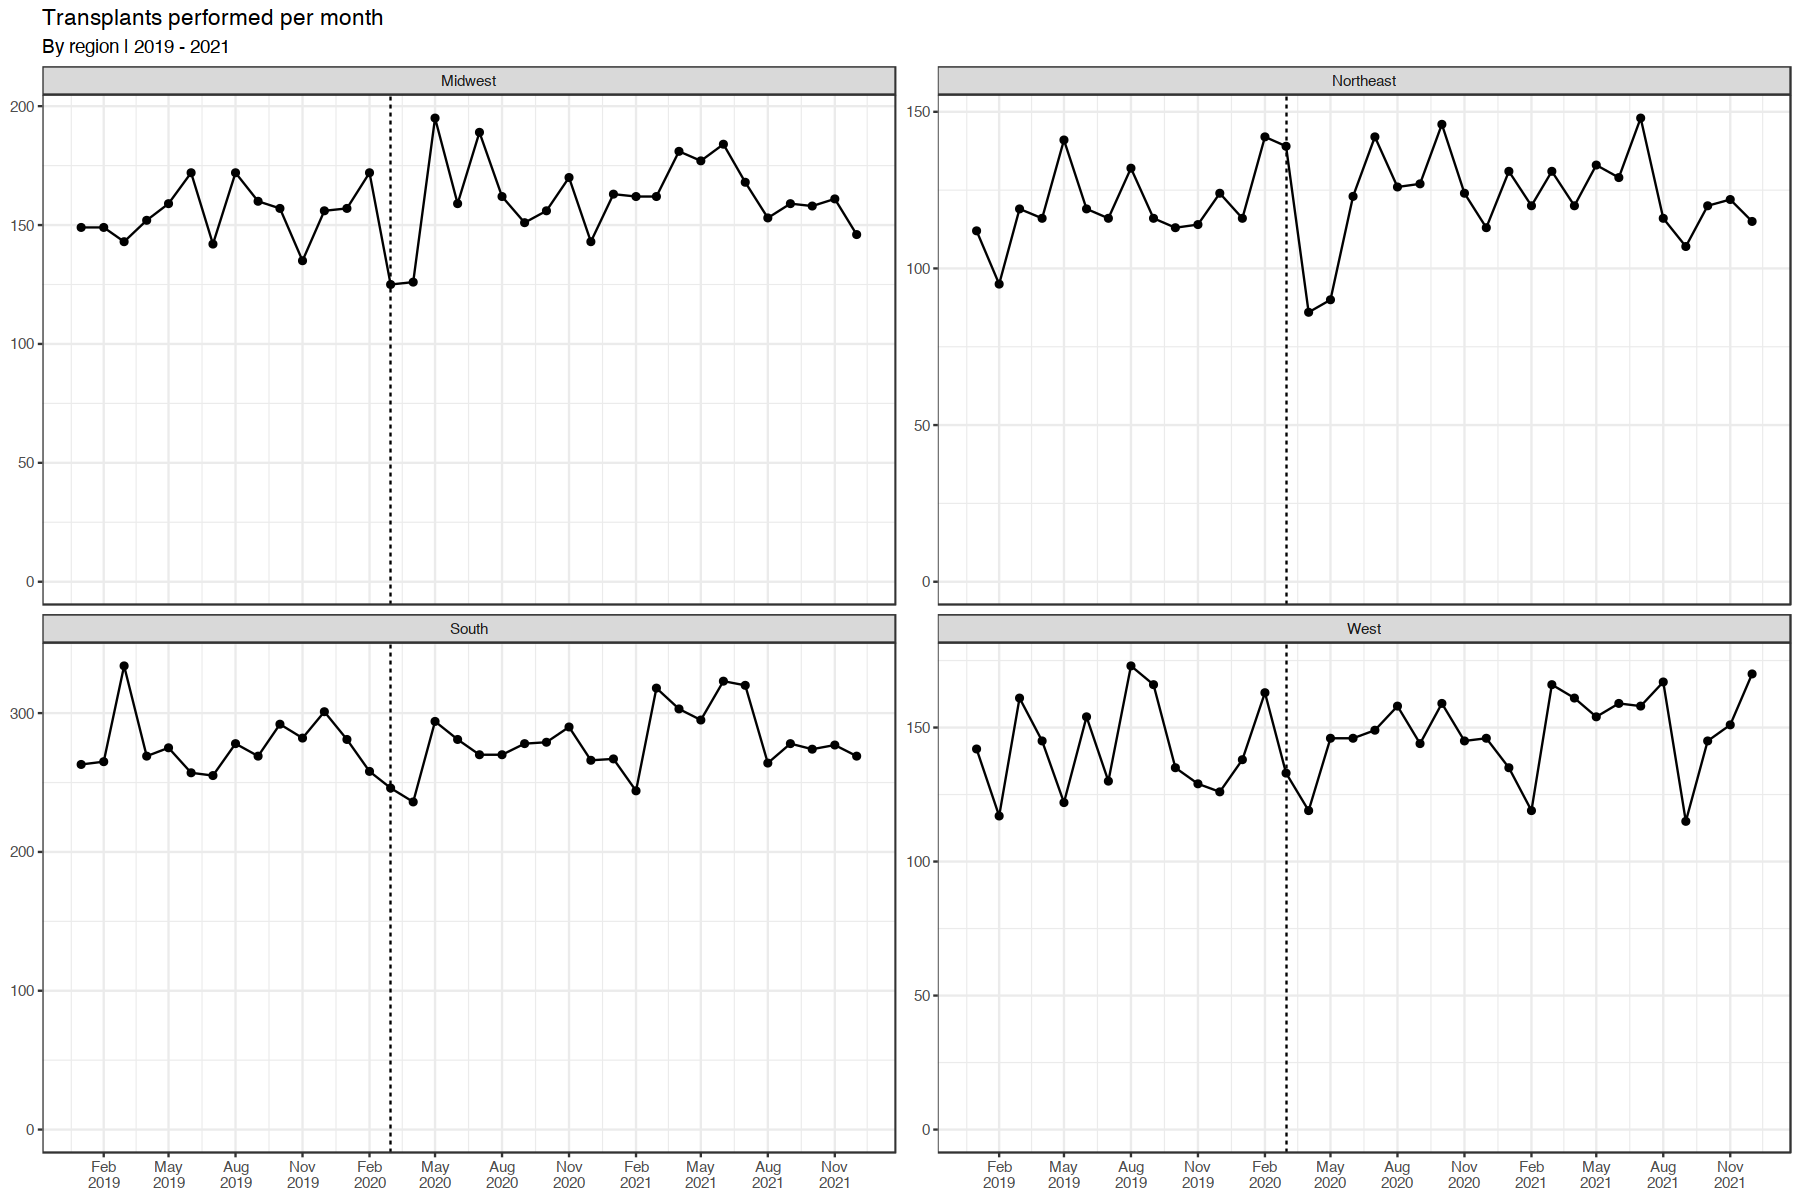

In [6]:
txByMonthCOVID.plot2 <- transplant %>%
  filter(REC_TX_DT_YEAR %in% 2019:2021) %>%
  tidylog::filter(!is.na(CAN_HOSPITAL_STATE), !grepl("PR|VI", CAN_HOSPITAL_STATE)) %>%
  left_join(state_code_mapping, by = c("CAN_HOSPITAL_STATE" = "STATE_CODE")) %>%
  count(REC_TX_DT_MONTH = lubridate::floor_date(REC_TX_DT_DATE, "month"),
        STATE_REGION) %>%
  ggplot(aes(x = REC_TX_DT_MONTH, y = n)) +
  geom_vline(xintercept = as.Date("2020-03-01"), linetype = "dashed") +
  geom_line() +
  geom_point() +
  scale_x_date(name = NULL, date_labels = "%b\n%Y", date_breaks = "3 months") +
  scale_y_continuous(name = NULL) +
  expand_limits(y = 0) +
  facet_wrap(~ STATE_REGION, scale = "free_y") +
  labs(title = "Transplants performed per month",
       subtitle = "By region | 2019 - 2021") +
  theme_bw()

ggsave("output/figures/fig8-transplants_per_month_by_region_around_covid.png",
       txByMonthCOVID.plot2, device = "png",
       width = 10, height = 6, unit = "in")

txByMonthCOVID.plot2

Warning message:
“Removed 29 row(s) containing missing values (geom_path).”


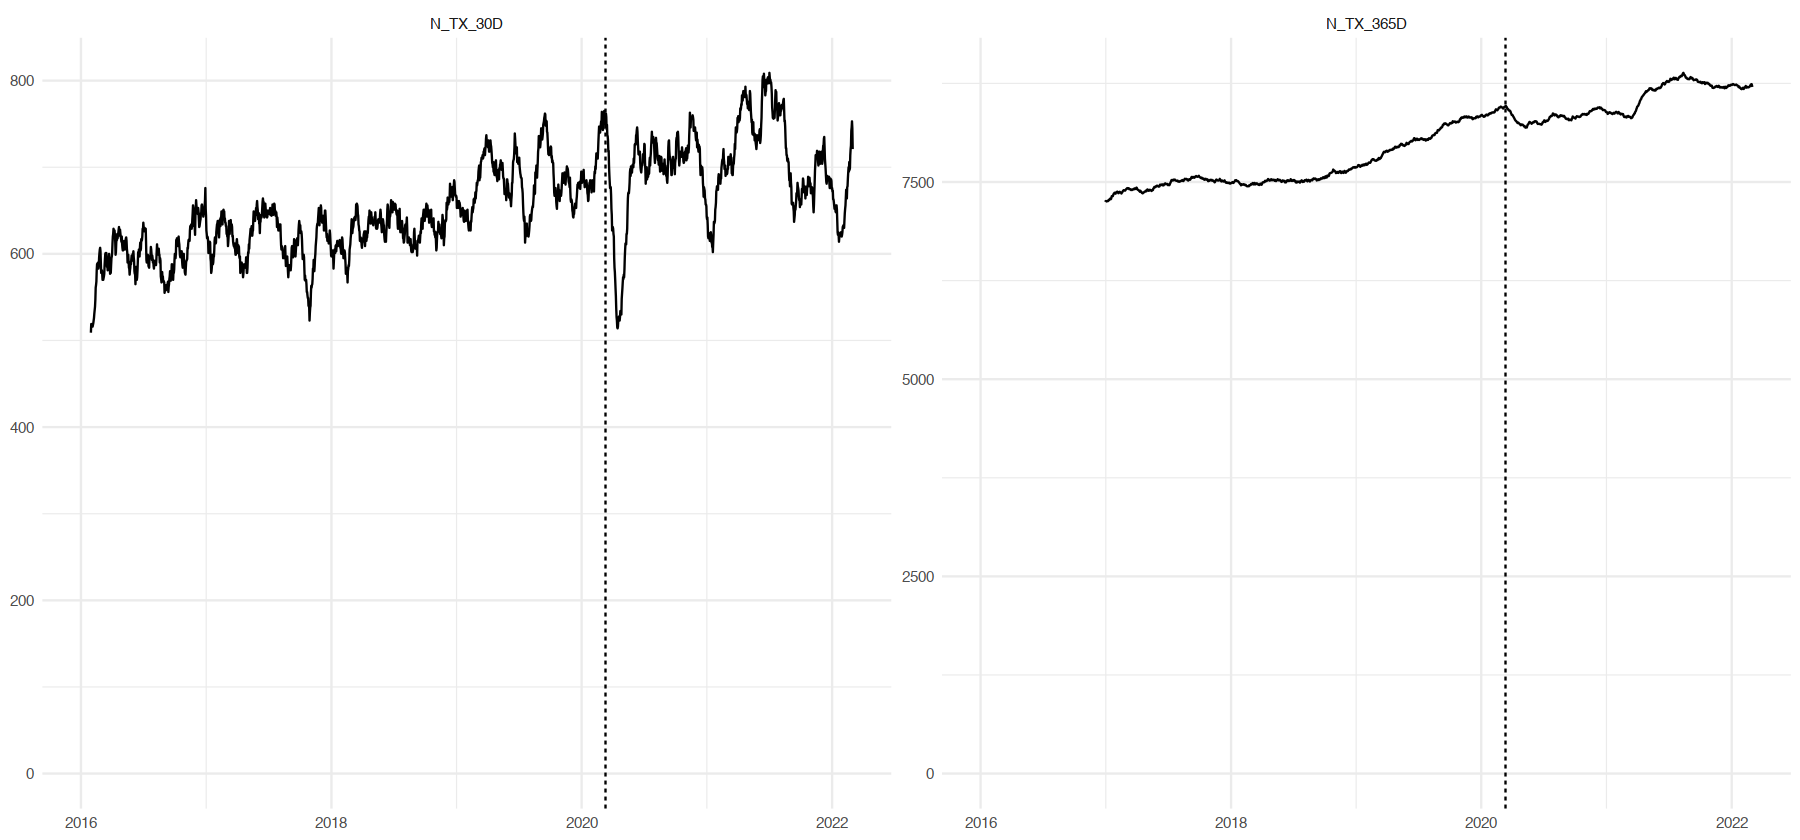

In [7]:
options(repr.plot.width = 15, repr.plot.height = 7)

txDuringCOVID.dt <- transplant.raw %>%
  mutate(REC_TX_DT_DATE = as.Date(REC_TX_DT, "%m/%d/%Y")) %>%
  filter(REC_AGE_AT_TX %in% c("18-34", "35-49", "50-64", "65+", "Unknown"),
         REC_TX_DT_DATE >= as.Date("2016-01-01")) %>%
  count(REC_TX_DT_DATE, name = "N_TX") %>%
  full_join(tibble(REC_TX_DT_DATE = seq.Date(min(.$REC_TX_DT_DATE), max(.$REC_TX_DT_DATE), "day")),
            by = "REC_TX_DT_DATE") %>%
  mutate(N_TX_30D = zoo::rollsum(N_TX, 30, na.pad = T, align = "right"),
         N_TX_365D = zoo::rollsum(N_TX, 365, na.pad = T, align = "right"))

write.csv(txDuringCOVID.dt, "output/tables/table8-tx_during_covid_months_rolling.csv",
          row.names = F)

txDuringCOVID.dt %>%
  pivot_longer(matches("N_TX_(30|365)D"), names_to = "SERIES", values_to = "VALUE") %>%
  ggplot(aes(x = REC_TX_DT_DATE, y = VALUE)) +
  geom_vline(xintercept = as.Date("2020-03-12"), linetype = "dashed") +
  geom_line() +
  facet_wrap(~ SERIES, scales = "free_y") +
  expand_limits(y = 0) +
  labs(x = NULL, y = NULL) +
  theme_minimal() 